## Counterfactual predictions for impact variables

This section provides more details on the way counterfactual predictions are carried out by `eensight` for events that affect **impact variables**, such as an energy retrofit. To this end, it outlines the methodology behind the `predict` and `evaluate` pipelines of `eensight`.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import time

import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from eensight.config import ConfigLoader
from eensight.methods.prediction.baseline import UsagePredictor
from eensight.methods.prediction.activity import estimate_activity
from eensight.methods.prediction.metrics import cvrmse, nmbe
from eensight.settings import PROJECT_PATH
from eensight.utils import get_categorical_cols, load_catalog

plt.style.use("bmh")

%matplotlib inline

### The *b02* dataset

The *b02* dataset corresponds to the building with `id=13` of the dataset provided by the [EnergyDetective 2020](https://zenodo.org/record/6590976) competition. 

Start with the `train` data:

In [3]:
catalog_train = load_catalog(store_uri="../../../data", site_id="b02", namespace="train")

X_train = catalog_train.load("train.preprocessed-features")
y_train = catalog_train.load("train.preprocessed-labels")

The following plot presents the energy consumption of the selected dataset as a function of the outdoor temperature:

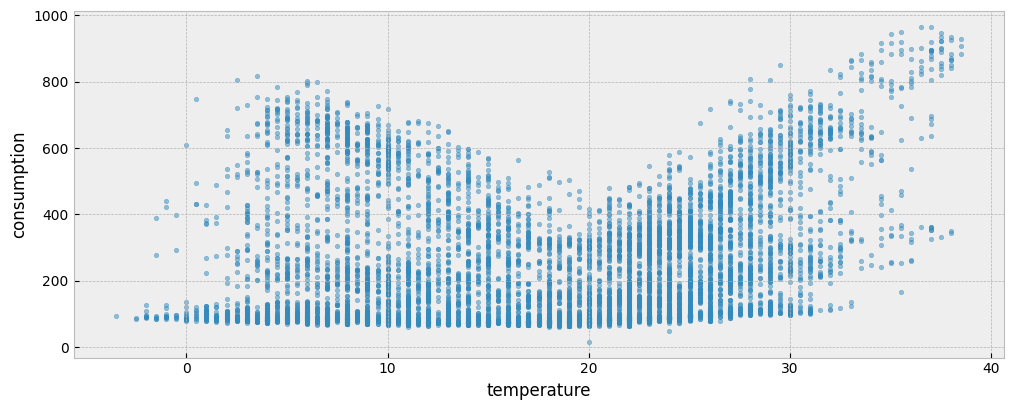

In [4]:
fig = plt.figure(figsize=(12, 4.5))
layout = (1, 1)
ax = plt.subplot2grid(layout, (0, 0))

ax.scatter(X_train["temperature"], y_train["consumption"], s=10, alpha=0.5)
ax.set_xlabel("temperature")
ax.set_ylabel("consumption")

### The `predict` pipeline

The `predict` pipeline performs the following steps:

**When run in the `train` namespace**

Fits a predictive model on the `train` data using the `eensight.methods.prediction.baseline.UsagePredictor` model. We don't need to add calendar features, since the `UsagePredictor` adds calendar features as needed: 

In [5]:
model = UsagePredictor().fit(X_train, y_train)

The `predict` pipeline can be called from the command line as:

```bash
eensight run predict --site-id b02 --store-uri ../../../data --namespace train 
```

Running the pipeline will create the following artifacts:

* `model`: The trained `UsagePredictor` model


* `train.prediction`: A dataframe with the prediction generated by applying the `model` on the `train` data (in-sample prediction)


* `train.performance`: A JSON file with the in-sample CV(RMSE) and NMBE.

**When run in the `test` namespace**

Load the `test` data:

In [7]:
catalog_test = load_catalog(store_uri="../../../data", site_id="b02", namespace="test")

X_test = catalog_test.load("test.preprocessed-features")
y_test = catalog_test.load("test.preprocessed-labels")

Both the `train` and `test` period consumption data are presented in the next plot:

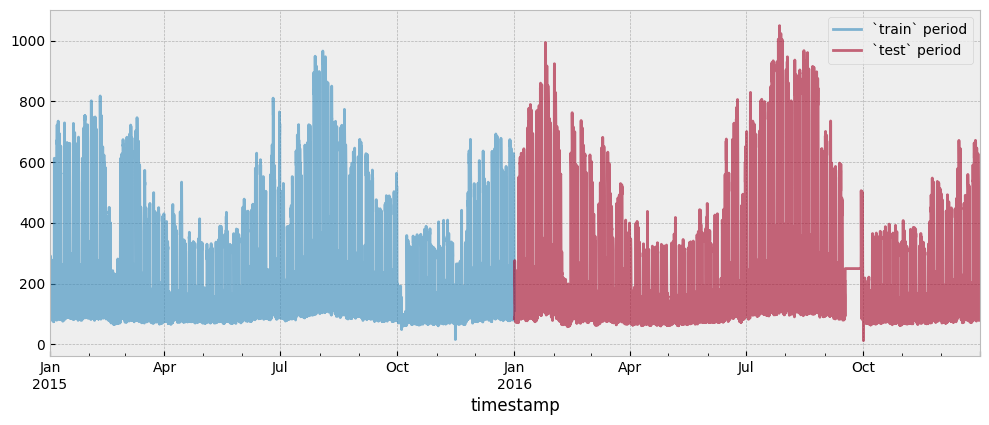

In [9]:
fig = plt.figure(figsize=(12, 4.5))
layout = (1, 1)
ax = plt.subplot2grid(layout, (0, 0))

y_train.plot(ax=ax, alpha=0.6)
y_test.plot(ax=ax, alpha=0.6)
ax.legend(["`train` period", "`test` period"], frameon=True)

Apply the model on the `test` data:

In [10]:
prediction = model.predict(X_test)

The Coefficient of Variation of the Root Mean Squared Error CV(RMSE) is:

In [11]:
cvrmse(y_test, prediction)

0.3042765589248083

The Normalized Mean Bias Error (NMBE) is:

In [12]:
nmbe(y_test, prediction)

0.007393580383622497

The `UsagePredictor` model allows us to add time lags for selected features. If we want to add 1-hour, 2-hour and 24-hour time lags for `temperature`, we can write:

In [13]:
lags = {"temperature": [1, 2, 24]}

model = UsagePredictor(lags=lags).fit(X_train, y_train)

Adding time lags may improve the accuracy of the model:

In [14]:
prediction = model.predict(X_test)
cvrmse(y_test, prediction)

0.29944357827501156

In [15]:
nmbe(y_test, prediction)

0.005027632126261972

The `predict` pipeline can be called from the command line as:

```bash
eensight run predict --site-id b02 --store-uri ../../../data --namespace test 
```

Running the pipeline will create the following artifacts:

* `test.prediction`: A dataframe with the prediction generated by applying the `model` on the `test` data (out-of-sample prediction)

To actually get the metrics for the predictive performance of the model, we have to call the `evaluate` pipeline:

```bash
eensight run evaluate --site-id b02 --store-uri ../../../data --namespace test 
```

Running the pipeline will create the following artifacts:

* `test.performance`: A JSON file with the out-of-sample CV(RMSE) and NMBE.

Note that: 

1. The `predict` pipeline must be called first in the `train` namespace and, then, in the `test` one, so that the `model` is available.


2. The `predict` pipeline must be called before the `evaluate`, so that the `test.prediction` is available to the latter.


3. The `evaluate` pipeline supports only the `test` and `apply` namespaces.

**When run in the `apply` namespace**

We can use the fitted model to carry out a counterfactual prediction for the `apply` period:

In [16]:
catalog_apply = load_catalog(store_uri="../../../data", site_id="b02", namespace="apply")

X_apply = catalog_apply.load("apply.preprocessed-features")
y_apply = catalog_apply.load("apply.preprocessed-labels")

The `train`, `test` and `apply` period consumption data are presented in the next plot:

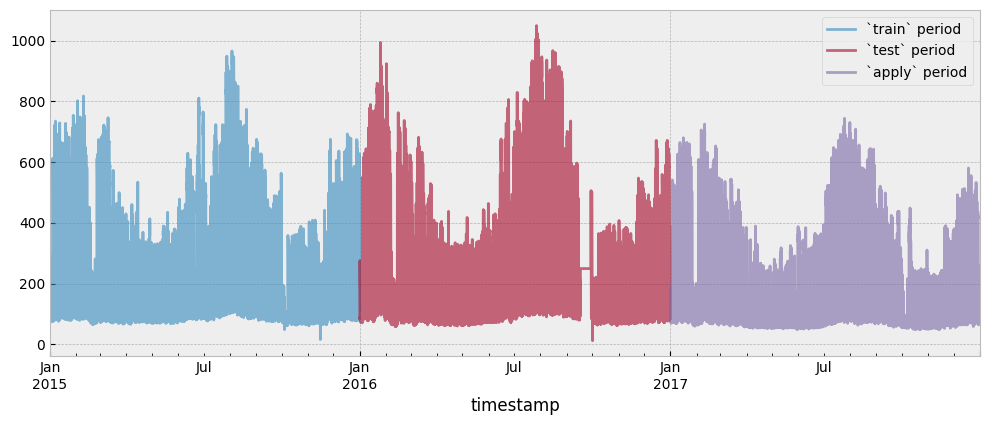

In [18]:
fig = plt.figure(figsize=(12, 4.5))
layout = (1, 1)
ax = plt.subplot2grid(layout, (0, 0))

y_train.plot(ax=ax, alpha=0.6)
y_test.plot(ax=ax, alpha=0.6)
y_apply.plot(ax=ax, alpha=0.6)

ax.legend(["`train` period", "`test` period", "`apply` period"], frameon=True)

Evaluate the model on the `apply` data:

In [19]:
prediction = model.predict(X_apply)

Since `train` and `apply` data are separated by an event (`train` is pre-event data and `apply` is post-event), the difference between the predicted and the actual energy consumption is an estimation of the event's impact. 

In [20]:
impact = prediction - y_apply["consumption"]

Typically, the impact (expressed in this case as energy savings) is visualized as a cumulative variable:

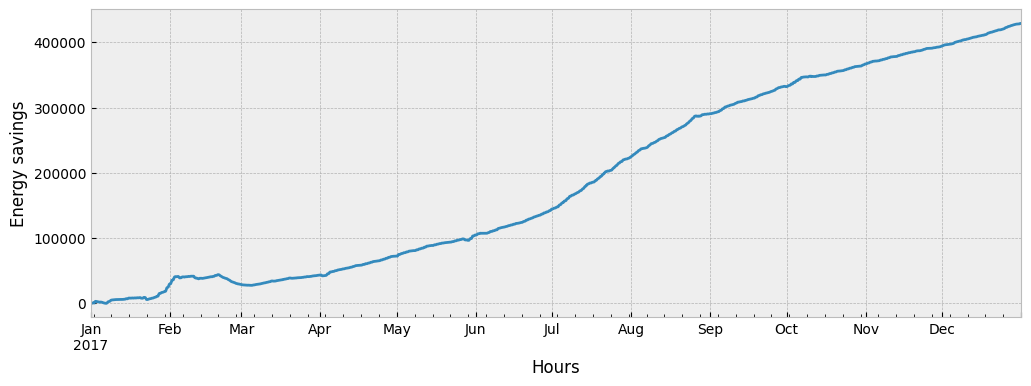

In [21]:
fig = plt.figure(figsize=(12, 4))
layout = (1, 1)
ax = plt.subplot2grid(layout, (0, 0))

impact.cumsum().plot(ax=ax)

ax.set_xlabel('Hours')
ax.set_ylabel('Energy savings')

The `predict` pipeline can be called from the command line as:

```bash
eensight run predict --site-id b02 --store-uri ../../../data --namespace apply 
```

Running the pipeline will create the following artifacts:

* `apply.prediction`: A dataframe with the prediction generated by applying the `model` on the `apply` data (counterfactual prediction)

To actually get the impact estimation, we have to call the `evaluate` pipeline:

```bash
eensight run evaluate --site-id b02 --store-uri ../../../data --namespace apply 
```

Running the pipeline will create the following artifacts:

* `apply.impact`: A dataframe with the difference between the predicted and the actual energy consumption.

Note that the `predict` pipeline must be called before the `evaluate`, so that the `apply.prediction` is available to the latter.

In practice, the predicitive model can be used for generating counterfactual energy consumption predictions until we observe enough data in the reporting period. When enough data is available, we can run the `predict` pipeline with the flag `--autoencode`. 

In this case:

### The `predict` pipeline with autoencoding

**When run in the `train` namespace**

First, estimate activity levels. 

In [27]:
for feature in X_train.columns:
    print(feature)

temperature
dew point temperature
relative humidity
atmospheric pressure
wind speed


In [66]:
non_occ_features = [
    "temperature",
    "dew point temperature",
    "relative humidity",
    "atmospheric pressure",
    "wind speed"
]

act_train = estimate_activity(
    X_train, 
    y_train, 
    non_occ_features=non_occ_features, 
    exog="temperature",
    n_trials=200,
    verbose=False,
)

Then, fit a predictive model for the `train` data using the activity estimation as a feature. In this case, we set the `UsagePredictor`'s parameter `skip_calendar` to `True`, so that calendar features are not generated automatically:

In [67]:
X_train_act = pd.concat(
    [
        X_train,
        act_train.to_frame("activity")
        
    ], 
    axis=1
)

model_autoenc = UsagePredictor(lags=lags, skip_calendar=True).fit(X_train_act, y_train)

The `predict` pipeline can be called from the command line as:

```bash
eensight run predict --site-id b02 --store-uri ../../../data --namespace train --autoencode
```

Running the pipeline will create the following artifacts:

* `train.activity`: Dataframe with the estimated activity levels for the `train` data.


* `model-autoenc`: The trained `UsagePredictor` model using activity levels as a feature.


* `train.prediction-autoenc`: A dataframe with the prediction generated by applying `model-autoenc` on the `train` data.


* `train.performance-autoenc`: A JSON file with the CV(RMSE) and NMBE.

**When run in the `test` namespace**

Estimate activity levels:

In [68]:
act_test = estimate_activity(
    X_test, 
    y_test, 
    non_occ_features=non_occ_features, 
    exog="temperature",
    n_trials=200,
    verbose=False,
)

Use the model that was fitted on the `train` data to predict energy consumption:

In [69]:
X_test_act = pd.concat(
    [
        X_test,
        act_test.to_frame("activity")
    ], 
    axis=1
)

prediction = model_autoenc.predict(X_test_act)

Autoencoding improves predictive accuracy on `test` data, but not in a drastic way that would indicate overfitting due to data leakage:

In [70]:
cvrmse(y_test, prediction)

0.2805189614516902

In [71]:
nmbe(y_test, prediction)

0.03583116402388926

The `predict` pipeline can be called from the command line as:

```bash
eensight run predict --site-id b02 --store-uri ../../../data --namespace test --autoencode
```

Running the pipeline will create the following artifacts:

* `test.activity`: Dataframe with the estimated activity levels for the `test` data.


* `test.prediction-autoenc`: A dataframe with the prediction generated by applying `model-autoenc` on the `test` data

To actually get the metrics for the predictive performance of the model, we have to call the `evaluate` pipeline:

```bash
eensight run evaluate --site-id b02 --store-uri ../../../data --namespace test --autoencode
```

Running the pipeline will create the following artifacts:

* `test.performance-autoenc`: A JSON file with the CV(RMSE) and NMBE values.

Note that the `predict` pipeline must be called before the `evaluate`, so that the `test.prediction-autoenc` is available to the latter.

**When run in the `apply` namespace**

Estimate activity levels:

In [72]:
act_apply = estimate_activity(
    X_apply, 
    y_apply, 
    non_occ_features=non_occ_features, 
    exog="temperature",
    n_trials=200,
    verbose=False,
)

If the `predict` pipeline runs on the `apply` data, the consumption model generates a counterfactual prediction:

In [73]:
X_counter = pd.concat(
    [
        X_apply,
        act_apply.to_frame("activity")
    ], 
    axis=1
)

prediction = model_autoenc.predict(X_counter)

In [74]:
impact_autoenc = prediction - y_apply["consumption"]

The `predict` pipeline can be called from the command line as:

```bash
eensight run predict --site-id b02 --store-uri ../../../data --namespace apply --autoencode
```

Running the pipeline will create the following artifacts:

* `apply.activity`: Dataframe with the estimated activity levels for the `apply` data.


* `apply.prediction-autoenc`: A dataframe with the prediction generated by applying `model-autoenc` on the `apply` data.

To actually get the impact estimation, we have to call the `evaluate` pipeline:

```bash
eensight run evaluate --site-id b02 --store-uri ../../../data --namespace apply --autoencode
```

Running the pipeline will create the following artifacts:

* `apply.impact-autoenc`: A dataframe with the difference between the predicted and the actual energy consumption.

Note that the `predict` pipeline must be called before the `evaluate`, so that the `apply.prediction-autoenc` is available to the latter.

We can compare the estimated impact from the two approaches:

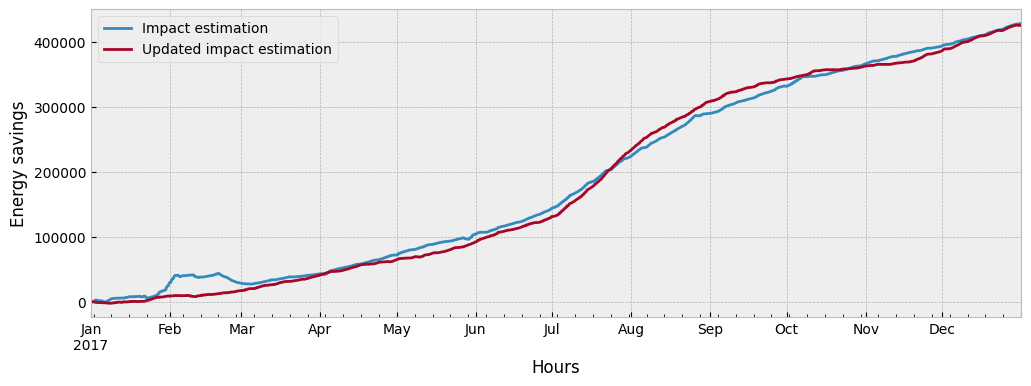

In [75]:
fig = plt.figure(figsize=(12, 4))
layout = (1, 1)
ax = plt.subplot2grid(layout, (0, 0))

impact.cumsum().plot(ax=ax)
impact_autoenc.cumsum().plot(ax=ax)

ax.set_xlabel('Hours')
ax.set_ylabel('Energy savings')
ax.legend(["Impact estimation", "Updated impact estimation"], frameon=True)

*What drives the difference between the two impact estimations and which one should we trust more?*

Let's isolate all `train` and `apply` observations where temperature is lower than 20$^{\circ}C$ and activity equals one (1):

In [76]:
low_temp_periods_train = X_train[X_train["temperature"] <= 20].index

y_train_selected = y_train[
    y_train.index.isin(low_temp_periods_train) 
    & y_train.index.isin(act_train[act_train == 1].index)
]

low_temp_periods_apply = X_apply[X_apply["temperature"] <= 20].index

y_apply_selected = y_apply[
    y_apply.index.isin(low_temp_periods_apply) 
    & y_apply.index.isin(act_apply[act_apply == 1].index)
]

We can plot the two subsets side by side:

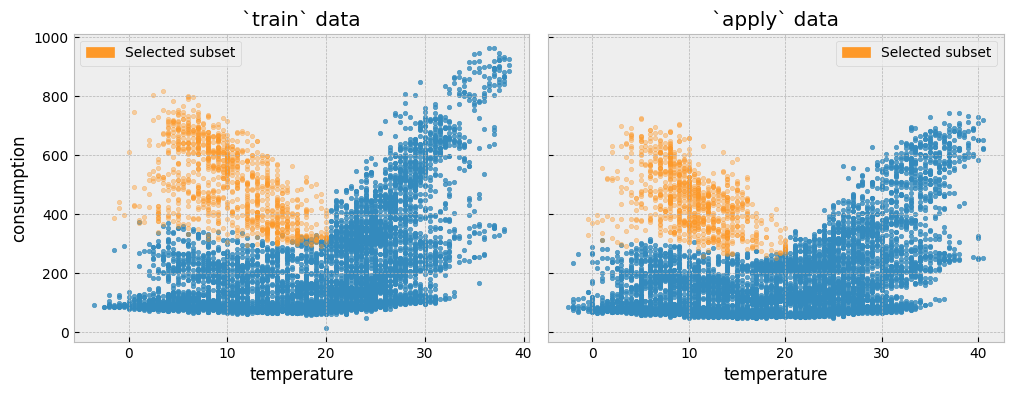

In [77]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 4))
fig.subplots_adjust(wspace=0.04)

ax1.scatter(
    X_train.loc[~X_train.index.isin(y_train_selected.index), "temperature"], 
    y_train.loc[~y_train.index.isin(y_train_selected.index), "consumption"], 
    s=10, 
    alpha=0.8
)

ax1.scatter(
    X_train.loc[y_train_selected.index, "temperature"], 
    y_train_selected["consumption"], 
    s=10, 
    alpha=0.4,
    color="#fe9929"
)

ax1.set_xlabel("temperature")
ax1.set_ylabel("consumption")
ax1.set_title("`train` data")

ax1.legend(
    handles=[
        mpatches.Patch(color="#fe9929", label="Selected subset"), 
    ]
)

ax2.scatter(
    X_apply.loc[~X_apply.index.isin(y_apply_selected.index), "temperature"], 
    y_apply.loc[~y_apply.index.isin(y_apply_selected.index), "consumption"],
    s=10, 
    alpha=0.8
)

ax2.scatter(
    X_apply.loc[y_apply_selected.index, "temperature"], 
    y_apply_selected["consumption"], 
    s=10, 
    alpha=0.4,
    color="#fe9929"
)

ax2.set_xlabel("temperature")
ax2.set_title("`apply` data")

ax2.legend(
    handles=[
        mpatches.Patch(color="#fe9929", label="Selected subset"), 
    ]
)

First, we will plot the distribution of the **actual** energy consumption for the selected `train` and the `apply` observations:

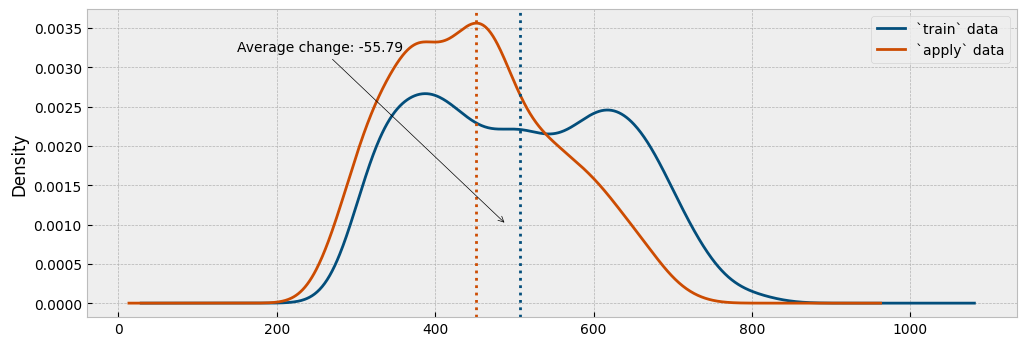

In [78]:
fig = plt.figure(figsize=(12, 4))
layout = (1, 1)
ax = plt.subplot2grid(layout, (0, 0))

y_train_selected.plot.kde(ax=ax, color="#034e7b")
y_apply_selected.plot.kde(ax=ax, color="#cc4c02")

selected_train_average = y_train_selected["consumption"].mean()
selected_apply_average = y_apply_selected["consumption"].mean()

ax.axvline(x=selected_train_average, color="#034e7b", ls=":")
ax.axvline(x=selected_apply_average, color="#cc4c02", ls=":")

ax.annotate(
    f"Average change: {round(selected_apply_average - selected_train_average, 2)}", 
    xy=(490, 0.001), 
    xytext=(150, 0.0032), 
    arrowprops={"arrowstyle":"->", "color":"black"}
)

ax.legend(["`train` data", "`apply` data"], frameon=True)

This is pretty much how a counterfactual prediction should work: find similar conditions between the pre- and post-event data (here, similar temperature and activity levels), and compare the difference in the energy consumption.

Next, we will estimate the energy consumption using the predictive model and compare the predicted with the actual consumption:

In [79]:
X_apply_selected = X_apply.loc[y_apply_selected.index]

prediction = model.predict(X_apply_selected)

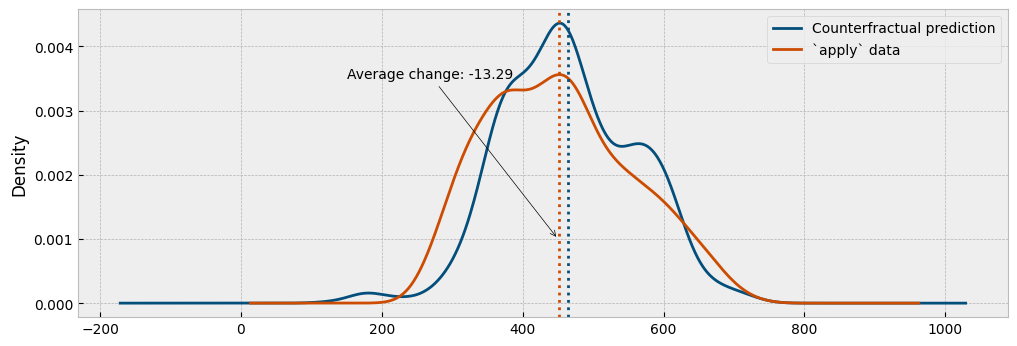

In [80]:
fig = plt.figure(figsize=(12, 4))
layout = (1, 1)
ax = plt.subplot2grid(layout, (0, 0))

prediction.plot.kde(ax=ax, color="#034e7b")
y_apply_selected.plot.kde(ax=ax, color="#cc4c02")

prediction_average = prediction.mean()
selected_apply_average = y_apply_selected["consumption"].mean()

ax.axvline(x=prediction_average, color="#034e7b", ls=":")
ax.axvline(x=selected_apply_average, color="#cc4c02", ls=":")

ax.annotate(
    f"Average change: {round(selected_apply_average - prediction_average, 2)}", 
    xy=(450, 0.001), 
    xytext=(150, 0.0035), 
    arrowprops={"arrowstyle":"->", "color":"black"}
)

ax.legend(["Counterfractual prediction", "`apply` data"], frameon=True)

Finally, we will estimate the energy consumption using the autoencoding model and compare the predicted with the actual consumption:

In [81]:
X_counter = pd.concat(
    [
        X_apply_selected,
        act_apply.loc[X_apply_selected.index].to_frame("activity")
    ], 
    axis=1
)

prediction = model_autoenc.predict(X_counter)

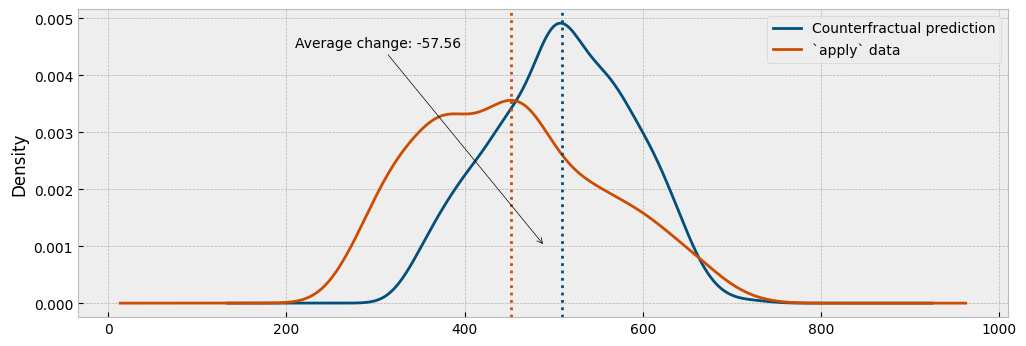

In [82]:
fig = plt.figure(figsize=(12, 4))
layout = (1, 1)
ax = plt.subplot2grid(layout, (0, 0))

prediction.plot.kde(ax=ax, color="#034e7b")
y_apply_selected.plot.kde(ax=ax, color="#cc4c02")

prediction_average = prediction.mean()
selected_apply_average = y_apply_selected["consumption"].mean()

ax.axvline(x=prediction_average, color="#034e7b", ls=":")
ax.axvline(x=selected_apply_average, color="#cc4c02", ls=":")

ax.annotate(
    f"Average change: {round(selected_apply_average - prediction_average, 2)}", 
    xy=(490, 0.001), 
    xytext=(210, 0.0045), 
    arrowprops={"arrowstyle":"->", "color":"black"}
)

ax.legend(["Counterfractual prediction", "`apply` data"], frameon=True)

As we can see from the plots, the autoencoding approach provides a generally better representation of the actual impact. 

### The *b03* dataset

The *b03* data corresponds to the building with `id=50` from the dataset of the [Power Laws: Forecasting Energy Consumption](https://www.drivendata.org/competitions/51/electricity-prediction-machine-learning/page/101/) competition. 

Start with the `train` data:

In [83]:
catalog_train = load_catalog(store_uri="../../../data", site_id="b03", namespace="train")

X_train = catalog_train.load("train.preprocessed-features")
y_train = catalog_train.load("train.preprocessed-labels")

The following plot presents the energy consumption of the selected dataset as a function of the outdoor temperature:

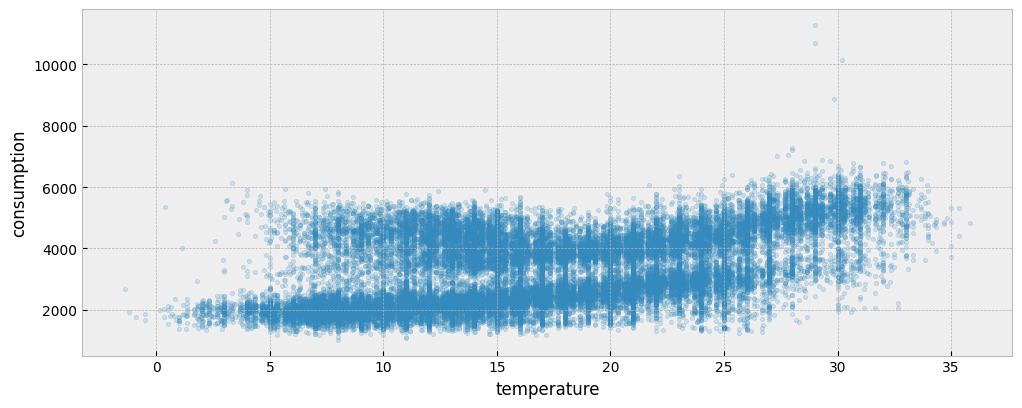

In [84]:
fig = plt.figure(figsize=(12, 4.5))
layout = (1, 1)
ax = plt.subplot2grid(layout, (0, 0))

ax.scatter(X_train["temperature"], y_train["consumption"], s=10, alpha=0.2)
ax.set_xlabel("temperature")
ax.set_ylabel("consumption")

### The `predict` pipeline

**When run in the `train` namespace**

Fit a predictive model on the `train` data using the `UsagePredictor` model. Note that there is one **categorical feature** in the data:

In [85]:
get_categorical_cols(X_train, int_is_categorical=False)

['holiday']

In [86]:
model = UsagePredictor(cat_features="holiday").fit(X_train, y_train)

**When run in the `apply` namespace**

Load the `apply` data:

In [87]:
catalog_apply = load_catalog(store_uri="../../../data", site_id="b03", namespace="apply")

X_apply = catalog_apply.load("apply.preprocessed-features")
y_apply = catalog_apply.load("apply.preprocessed-labels")

Both the `train` and `apply` period consumption data are presented in the next plot:

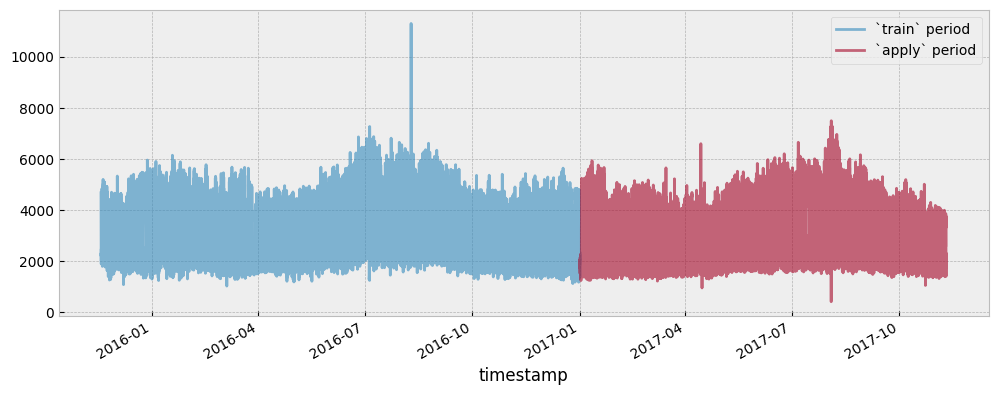

In [89]:
fig = plt.figure(figsize=(12, 4.5))
layout = (1, 1)
ax = plt.subplot2grid(layout, (0, 0))

y_train.plot(ax=ax, alpha=0.6)
y_apply.plot(ax=ax, alpha=0.6)
ax.legend(["`train` period", "`apply` period"], frameon=True)

Evaluate the model on the `apply` data:

In [90]:
prediction = model.predict(X_apply)

For this dataset, there is a time shift in the daily profiles between the `train` and the `apply` data. This time shift can be spotted when directly comparing the `train` and `apply` daily profiles:

In [91]:
y_train_daily = y_train.copy()
y_train_daily["date"] = y_train_daily.index.date
y_train_daily["time"] = y_train_daily.index.time

y_apply_daily = y_apply.copy()
y_apply_daily["date"] = y_apply_daily.index.date
y_apply_daily["time"] = y_apply_daily.index.time

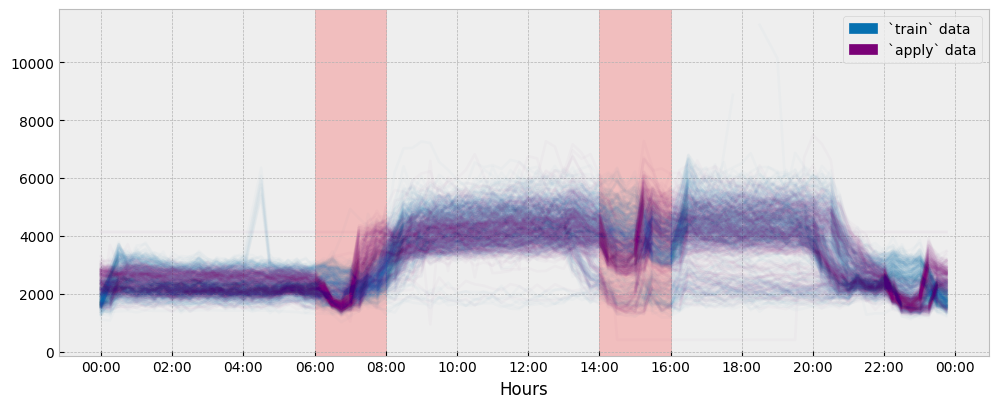

In [92]:
fig = plt.figure(figsize=(12, 4.5))
layout = (1, 1)
ax = plt.subplot2grid(layout, (0, 0))

y_train_daily.pivot(index="time", columns="date", values="consumption") \
             .plot(ax=ax, alpha=0.02, legend=None, color='#0570b0')
y_apply_daily.pivot(index="time", columns="date", values="consumption") \
             .plot(ax=ax, alpha=0.02, legend=None, color='#7a0177')

ax.axvspan(time(6, 0), time(8, 0), alpha=0.2, color="red")
ax.axvspan(time(14, 0), time(16, 0), alpha=0.2, color="red")

ax.xaxis.set_major_locator(ticker.MultipleLocator(3600*2))
ax.set_xlabel('Hours')

ax.legend(
    handles=[
        mpatches.Patch(color="#0570b0", label="`train` data"), 
        mpatches.Patch(color="#7a0177", label="`apply` data")
    ]
)

The plot suggests a significant misalignment in the occupancy patterns between the `train` and `apply` data during the hour intervals of 06:00-08:00 and 14:00-16:00. Let's see if we are able to capture it:

In [93]:
change = y_apply["consumption"] - prediction # as consumption increase

change_daily = change.to_frame("change")
change_daily["date"] = change_daily.index.date
change_daily["time"] = change_daily.index.time

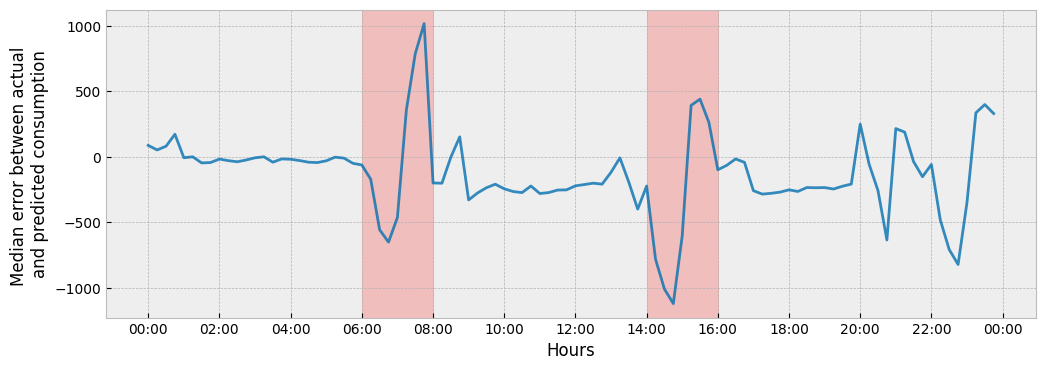

In [94]:
fig = plt.figure(figsize=(12, 4))
layout = (1, 1)
ax = plt.subplot2grid(layout, (0, 0))

change_daily.pivot(index='time', columns='date', values='change') \
            .mean(axis=1)                                      \
            .plot(ax=ax, alpha=0.8, legend=None, color='#0570b0')

ax.axvspan(time(6, 0), time(8, 0), alpha=0.2, color="red")
ax.axvspan(time(14, 0), time(16, 0), alpha=0.2, color="red")

ax.xaxis.set_major_locator(ticker.MultipleLocator(3600*2))
ax.set_xlabel('Hours')
ax.set_ylabel('Median error between actual \nand predicted consumption')

### The `predict` pipeline with autoencoding

**When run in the `train` namespace**

Estimate activity levels for the `train` data:

In [95]:
for feature in X_train.columns:
    print(feature)

holiday
temperature


In [96]:
act_train = estimate_activity(
    X_train, 
    y_train, 
    non_occ_features="temperature", 
    exog="temperature",
    n_trials=200,
    verbose=False,
)

Then, fit a predictive model for the `train` data using the activity estimation as a feature, while removing occupancy related features:

In [97]:
X_train_act = pd.concat(
    [
        X_train.drop("holiday", axis=1),
        act_train.to_frame("activity")
        
    ], 
    axis=1
)

model = UsagePredictor(skip_calendar=True).fit(X_train_act, y_train)

**When run in the `apply` namespace**

Estimate activity:

In [110]:
act_apply = estimate_activity(
    X_apply, 
    y_apply, 
    non_occ_features="temperature", 
    exog="temperature",
    n_trials=200,
    verbose=False,
)

Apply the predictive model:

In [111]:
X_apply_act = pd.concat(
    [
        X_apply.drop("holiday", axis=1),
        act_apply.to_frame("activity")
    ], 
    axis=1
)

prediction = model.predict(X_apply_act)

Calculate the impact from the change:

In [112]:
change_auto = y_apply["consumption"] - prediction # as consumption increase

change_daily_auto = change_auto.to_frame("change")
change_daily_auto["date"] = change_daily_auto.index.date
change_daily_auto["time"] = change_daily_auto.index.time

The next plot shows the two impact estimations together:

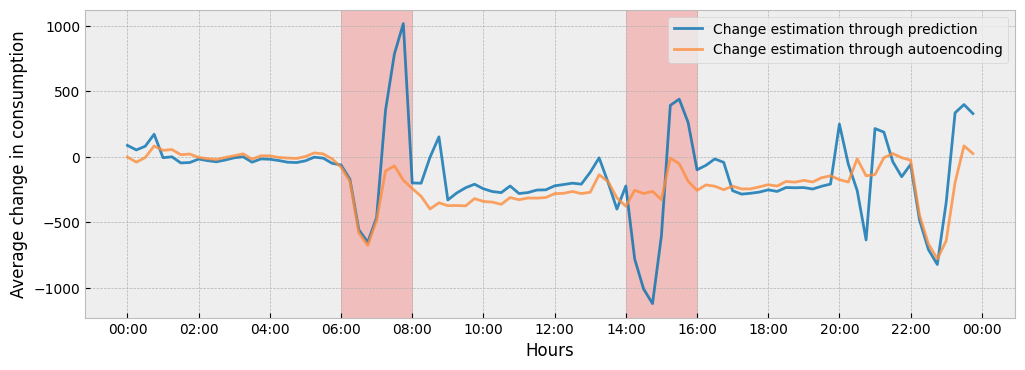

In [113]:
fig = plt.figure(figsize=(12, 4))
layout = (1, 1)
ax = plt.subplot2grid(layout, (0, 0))

change_daily.pivot(index='time', columns='date', values='change') \
               .mean(axis=1)                                      \
               .plot(ax=ax, alpha=0.8, legend=None, color='#0570b0')

change_daily_auto.pivot(index='time', columns='date', values='change') \
               .mean(axis=1)                                      \
               .plot(ax=ax, alpha=0.8, legend=None, color='#fd8d3c')

ax.legend(
    [
        "Change estimation through prediction", 
        "Change estimation through autoencoding"
    ], 
    frameon=True
)

ax.axvspan(time(6, 0), time(8, 0), alpha=0.2, color="red")
ax.axvspan(time(14, 0), time(16, 0), alpha=0.2, color="red")

ax.xaxis.set_major_locator(ticker.MultipleLocator(3600*2))
ax.set_xlabel('Hours')
ax.set_ylabel('Average change in consumption')

To understand the difference between the two (2) impact estimations, we can see how the estimated activity levels in `train` and `apply` periods differ from each other:

In [102]:
act_train_daily = act_train.to_frame("activity")
act_train_daily["date"] = act_train_daily.index.date
act_train_daily["time"] = act_train_daily.index.time

act_apply_daily = act_apply.to_frame("activity")
act_apply_daily["date"] = act_apply_daily.index.date
act_apply_daily["time"] = act_apply_daily.index.time

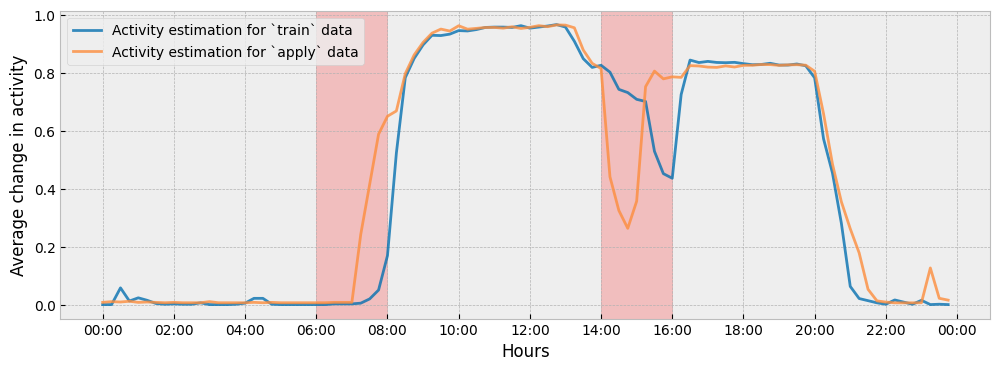

In [103]:
fig = plt.figure(figsize=(12, 4))
layout = (1, 1)
ax = plt.subplot2grid(layout, (0, 0))

act_train_daily.pivot(index='time', columns='date', values='activity') \
               .mean(axis=1)                                      \
               .plot(ax=ax, alpha=0.8, legend=None, color='#0570b0')

act_apply_daily.pivot(index='time', columns='date', values='activity') \
               .mean(axis=1)                                      \
               .plot(ax=ax, alpha=0.8, legend=None, color='#fd8d3c')

ax.legend(
    [
        "Activity estimation for `train` data", 
        "Activity estimation for `apply` data"
    ], 
    frameon=True
)

ax.axvspan(time(6, 0), time(8, 0), alpha=0.2, color="red")
ax.axvspan(time(14, 0), time(16, 0), alpha=0.2, color="red")

ax.xaxis.set_major_locator(ticker.MultipleLocator(3600*2))
ax.set_xlabel('Hours')
ax.set_ylabel('Average change in activity')

The autoencoding approach gives much less weight to changes in energy consumption that can be accounted for by changes in activity levels. For instance: 

* There is a change in the activity levels during the hour interval of 07:00-08:00, so the impact that is estimated by the autoencoding approach during this interval will be lower than the impact estimated by the prediction-based approach.


* The autoencoding approach regards the change of energy consumption during the hour interval of 14:00-16:00 mainly as activity driven (a shift in activity levels) and, as a result, the counterfactual prediction for this interval is practically flat.

Finally, the following plot shows the estimated activity levels along with the actual energy consumption for the `apply` period and for the first two (2) weeks of January:   

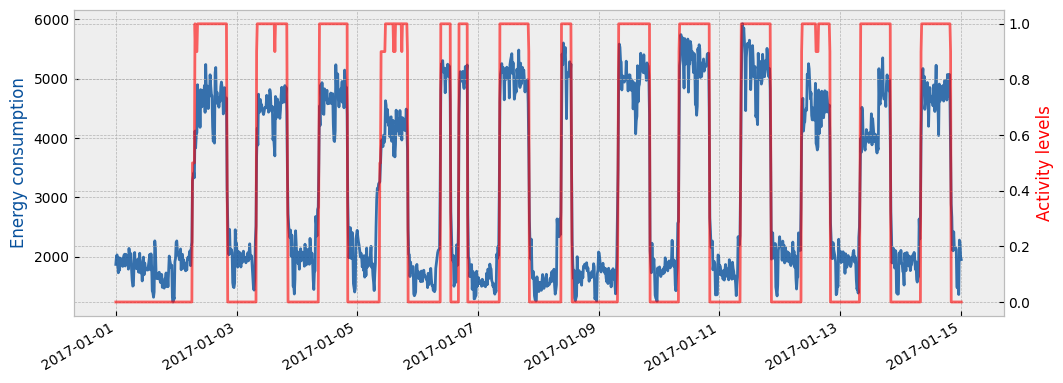

In [114]:
month = 1 # January
n_obs = 14*24*4

fig = plt.figure(figsize=(12, 4.5))
layout = (1, 1)
ax1 = plt.subplot2grid(layout, (0, 0))
ax2 = ax1.twinx()

y_apply["consumption"].loc[y_apply.index.month==month][:n_obs].plot(
    ax=ax1, color="#08519c", alpha=0.8
)
act_apply.loc[act_apply.index.month==month][:n_obs].plot(ax=ax2, color="red", alpha=0.6)


ax1.set_ylabel("Energy consumption", color="#08519c")
ax2.set_ylabel("Activity levels", color="red")
ax1.set_xlabel("")

## Parameters

The relevant parameters - as they can be found in the `eensight/conf/base/parameters/predict.yml` file - are:

In [5]:
params = ConfigLoader(PROJECT_PATH / "conf").get("parameters*", "parameters*/**", "**/parameters*")

In [7]:
params = {
    "fit": params["fit"],
    "activity": params["activity"]
}

for name in ("assume_hurdle", "n_trials_adjust", "upper_bound"):
    params["activity"].pop(name)
    
params

{
    'fit': {'lags': {'temperature': [1, 2, 24]}, 'cat_features': 'holiday', 'validation_size': 0.2},
    'activity': {
        'non_occ_features': 'temperature',
        'cat_features': 'holiday',
        'exog': 'temperature',
        'n_trials': 200,
        'verbose': True
    }
}

---------------------------